In [3]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum
import numpy as np
from sklearn.model_selection import KFold

# Cuando los splits son muy chicos o el accuracy es muy malo y no aparecen todos digitos se invalida el F-score para esos labels
# Lo siguiente es para evitar el menssudo apt-get install libbz2-devaje de warning al calcular el F-score
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


from sklearn.metrics import ConfusionMatrixDisplay
np.random.seed(1998)


/home/eitancho/Escritorio/tp2-nuevo/notebooks
Python 3.8.0


/home/eitancho/.pyenv/versions/3.8.0/envs/tp2_3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# K fold configuration y split simple
---

In [4]:

# Retorna el par data/labels a partir de un dataframe
def Xypair(dataset):
    X = dataset[dataset.columns[1:]].values
    y = dataset["label"].values.reshape(-1,1)
    return (X,y)

# Retorna k splits a partir del dataset (train/test) en pares (data/labels) o (X,y)
def Kfoldconfig(dataset, K):
    kfold = KFold(K, shuffle= True, random_state= 7)
    splits = []
    for train, test in kfold.split(dataset):
        splits.append((Xypair(dataset.iloc[train]), Xypair(dataset.iloc[test])))
    return splits

def singlesplit(dataset, limit):
    train_data = Xypair(dataset[:int(limit)])
    val_data = Xypair(dataset[int(limit):])
    return (train_data, val_data)

# Buscamos valores óptimos con un subconjunto de los datos

In [6]:
df_train = pd.read_csv("../data/train.csv.gz")
df_30000 = df_train.sample(30000)
df_20000 = df_train.sample(20000)
df_10000 = df_train.sample(10000)




## Visualización del dataset

In [7]:
def showImageExample(df, i_img):
    X_all , Y_all = Xypair(df)
    img = X_all[i_img]
    lbl = Y_all[i_img]

    img = img.reshape(28, 28)

    plt.imshow(img, cmap="Greys");
    plt.title("{}".format(lbl));

In [8]:
def visualizarMuestras(X_all, Y_all = np.array([]) , num_det = 0, Autovectors = False):
  #num_det = entre el 0 y el 9
  
  X_all2 = X_all.copy()
  if not Autovectors:
    Y_all2 = Y_all.copy()
    # pongo un 1 donde está el número y un 0 sino 
    Y_all2[Y_all == num_det] = 1
    Y_all2[Y_all != num_det] = 0
    xtemp = X_all2[Y_all2.reshape(-1,) == 1][:6]
    
  else: 
    xtemp = X_all2.T[:6]
  print(X_all2.shape)
  # visualizo algunas muestras

  img_mont = np.bmat([[xtemp[0].reshape(28,28),
            xtemp[1].reshape(28,28), 
            xtemp[2].reshape(28,28)],
            [xtemp[3].reshape(28,28), 
            xtemp[4].reshape(28,28),
            xtemp[5].reshape(28,28),]
        ])
  plt.imshow(img_mont, cmap="Greys")


In [9]:
def visualizarAutovectoresPCA(df, Avectors_qty):
    X, y = Xypair(df)
    pca = metnum.PCA(Avectors_qty)
    pca.fit(X)
    V = pca.eigenVectors()
    visualizarMuestras(V,Autovectors=True)

(42000, 784)


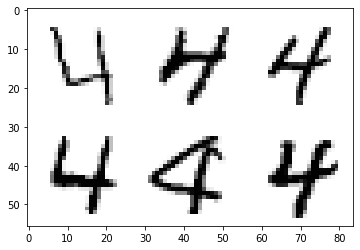

In [10]:
X , y = Xypair(df_train)
visualizarMuestras(X, y, 4)

(784, 6)


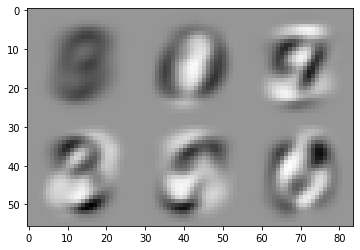

In [11]:
visualizarAutovectoresPCA(df_train,6)

## Graficamos

In [12]:
def dameMejorKSingle (metricaValues, kValues):
    maxValue = np.max(metricaValues)
    A = metricaValues[:] == maxValue
    for i in range(0, A.size):
        if A[i]:
            print ("El mejor parametro es", kValues[i]) 
            print ("el maximo de la métrica es", maxValue)
            return (kValues[i], maxValue)
            
def dameMejorKMultiple (metricas, kValues):
    maxMetricaValues = []
    kMejores = []
    for m in metricas: 
        k, maxValue = dameMejorKSingle(m, kValues)
        kMejores.append(k)
        maxMetricaValues.append(maxValue)
    return (kMejores, maxMetricaValues)


In [13]:
def mejorParametroEncontrado(A, parametro):
    tiempo = A["tiempo"].values     
    accuracy = A["accuracy"].values
    F1_score = A["F1-score"].values
    precision = A["precision"].values 
    recall = A["recall"].values 
    param = A[parametro].values
    mejoresAlphas, maxValues = dameMejorKMultiple(( accuracy, precision, recall, F1_score), param)

In [14]:



def graficarMetricas(A, parametro, title, xlabel, xlim, ylim):
    accuracy = A["accuracy"].values
    F1_score = A["F1-score"].values
    precision = A["precision"].values 
    recall = A["recall"].values 
    param = A[parametro].values
    if parametro == "Dataset":
        param = [100, 500, 1000, 5000, 10000, 20000, 30000, 42000]
    fig, axs = plt.subplots(nrows = 2, ncols = 2, sharex= True, sharey= True)

    axs[0,0].plot(param, accuracy, linewidth= 2.0)
    axs[0,1].plot(param, recall, color = "darkcyan", linewidth= 2.0)
    axs[1,0].plot(param, precision, color = "darkmagenta", linewidth= 2.0)
    axs[1,1].plot(param, F1_score, color = "darkgrey", linewidth= 2.0)

    axs[0,0].legend(["Accuracy"])
    axs[0,1].legend(["Recall"])
    axs[1,0].legend(["precision"])
    axs[1,1].legend(["F1-score"])
    for ax in axs:
        for a in ax:
            a.set_xlim(xlim)
            a.set_ylim(ylim)
    axs[1,1].set_xlabel(xlabel)
    axs[1,0].set_xlabel(xlabel)
    plt.suptitle(title)
    plt.show()

In [15]:
def compararPredictores(A1, A2, parametro, title, xlabel, xlim, ylimMetricas,ylimTiempo, legendA1, legendA2):
    parametro = A1[parametro].values
    size = parametro.shape[0]
    metricasA1 = (A1["accuracy"][:size] + A1["precision"][:size] + A1["recall"][:size] + A1["F1-score"][:size]).values/4
    metricasA2 = (A2["accuracy"][:size] + A2["precision"][:size] + A2["recall"][:size] + A2["F1-score"][:size]).values/4
    tiempoA1 = A1["tiempo"].values
    tiempoA2 = A2["tiempo"].values[:size]

    fig, axs = plt.subplots(nrows = 2, sharex = True)
    axs[0].plot(parametro, metricasA1, linestyle ="--", linewidth = 2)
    axs[0].plot(parametro, metricasA2, "darkcyan", linewidth = 2)
    axs[1].plot(parametro, tiempoA1, linestyle ="--", linewidth = 2)
    axs[1].plot(parametro, tiempoA2, "darkcyan", linewidth = 2)

    axs[0].set_ylim(ylimMetricas)
    axs[0].set_xlim(xlim)
    axs[1].set_ylim(ylimTiempo)
    axs[1].set_xlim(xlim)
    
    axs[0].axes.xaxis.set_visible(False)

    axs[0].legend(["metricas de "+legendA1, "metricas de " + legendA2])
    axs[1].legend(["tiempo de "+legendA1, "tiempo de " + legendA2])
    
    axs[1].set_xlabel(xlabel)
    fig.suptitle(title)

    plt.show()



In [21]:
def graficar_Confusion_Matrix(A, indice, con_etiquetas, dos_clases = False):
    
    cm = A.values[indice*10: indice*10 + 10, ]
    if dos_clases:
        cm = np.array([[cm[4,4], cm[4,9]],[cm[9,4], cm[9,9]]])

    if con_etiquetas:
        disp = ConfusionMatrixDisplay(cm,display_labels= np.arange(0,cm.shape[0]))
        disp.plot()
        plt.show()
    else:
        plt.imshow(cm)
        plt.xticks(np.arange(0,cm.shape[0]))
        plt.yticks(np.arange(0,cm.shape[0]))

In [18]:


def graficarTiempo(A, parametro, title, xlabel, xlim, ylim, multiplicar = False):
    param = A[parametro].values
    if parametro == "Dataset":
        param = [100,500,1000,5000,10000,20000,30000,42000]
    if (parametro == "K-folds") and multiplicar:
        tiempo = A["tiempo"].values * param
    else: 
        tiempo = A["tiempo"].values
    # plot
    fig, ax = plt.subplots()
    font = {'family':'serif','color':'darkred','size':15}
    ax.plot(param, tiempo, linewidth=2.0)
    ax.set(xlim=xlim, ylim=ylim)
    ax.set_xlabel( xlabel =xlabel, fontsize = 10)
    ax.legend(["Tiempo"])
    
    plt.show()
           

## 1) Variamos el numero de vecionos y vemos como afecta

* Se tomo un dataset de 10000 imágenes
* Parámetros de $K = 1$
* No se tomó *PCA*
* $k = [1 ... 8000]$


El mejor parametro es 4
el maximo de la métrica es 0.944
El mejor parametro es 5
el maximo de la métrica es 0.9476954451474529
El mejor parametro es 4
el maximo de la métrica es 0.9431409963829422
El mejor parametro es 5
el maximo de la métrica es 0.9442031605310692


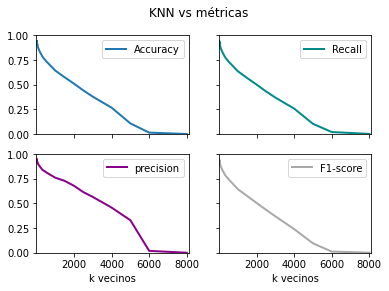

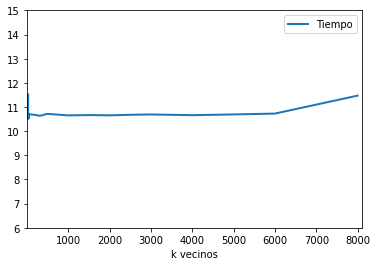

In [23]:
A = pd.read_csv("../results2/KNN/Variamos_KNN_SinPCA_10000.csv")
mejorParametroEncontrado(A,"k")
graficarMetricas(A, "k", "KNN vs métricas", "k vecinos", [1,8100], [0,1])
graficarTiempo(A, "k", "KNN vs Tiempo", "k vecinos", [1,8100], [6,15])

## 2) Variamos el parámetro $\alpha$ y vemos como afecta al experimento

* Se tomo un dataset de 20000 imágenes
* Parámetros de $K = 1$
* $\alpha = [1...700]$
* $k = 10$


El mejor parametro es 31
el maximo de la métrica es 0.95775
El mejor parametro es 31
el maximo de la métrica es 0.9585856345880052
El mejor parametro es 31
el maximo de la métrica es 0.9577077233910092
El mejor parametro es 31
el maximo de la métrica es 0.9578932449993888


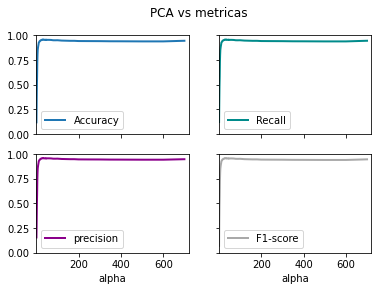

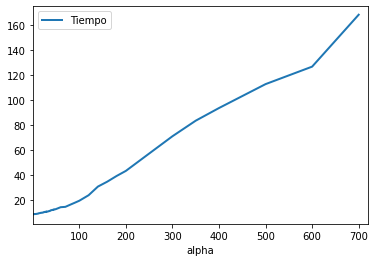

In [24]:
A = pd.read_csv("../results2/PCA/Variamos_Alpha_a_Extremos_20000.csv")
mejorParametroEncontrado(A,"alpha")
graficarMetricas(A, "alpha","PCA vs metricas", "alpha", [1,720], [0,1])
graficarTiempo(A,"alpha", "PCA vs Tiempo", "alpha", [1,720], [1,175])

## 3) Encontramos mejor k de KNN 

* Se tomo el dataset de 42000 imágenes
* Parámetros de $K = 1$
* No se tomó *PCA*
* $k = [1 ... 30]$


El mejor parametro es 3
el maximo de la métrica es 0.97
El mejor parametro es 3
el maximo de la métrica es 0.9706470644617884
El mejor parametro es 3
el maximo de la métrica es 0.969165545852426
El mejor parametro es 3
el maximo de la métrica es 0.9697167696389114


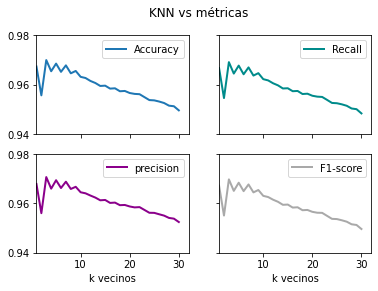

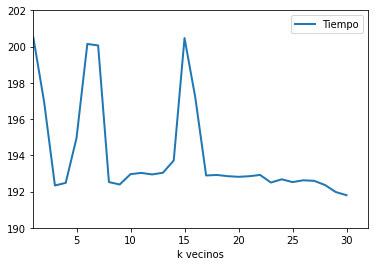

In [25]:
A = pd.read_csv("../results2/KNN/Encontramos_Mejor_k_de_KNN_en_dfTrain.csv")
mejorParametroEncontrado(A,"k")
graficarMetricas(A, "k", "KNN vs métricas", "k vecinos", [1,32], [0.94,0.98])
graficarTiempo(A, "k", "KNN vs Tiempo", "k vecinos", [1,32], [190,202])

## 4) Bucamos mejor $\alpha$ 

* Se tomo el dataset de 42000 imágenes
* Parámetros de $K = 1$
* $\alpha = [1...90]$
* $k = 3$

El mejor parametro es 36
el maximo de la métrica es 0.9746428571428573
El mejor parametro es 36
el maximo de la métrica es 0.9746110323827124
El mejor parametro es 36
el maximo de la métrica es 0.9742597859519913
El mejor parametro es 36
el maximo de la métrica es 0.9743846429916396


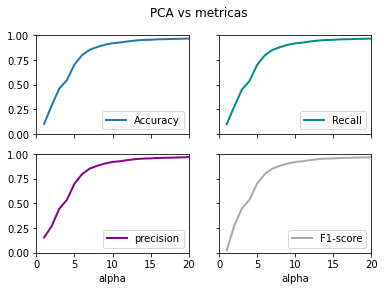

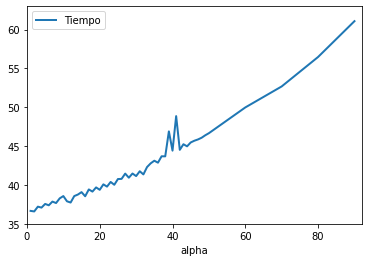

In [26]:
A = pd.read_csv("../results2/PCA/Bucamos_Mejor_alpha_en_df.csv")
mejorParametroEncontrado(A,"alpha")
graficarMetricas(A, "alpha","PCA vs metricas", "alpha", [0,20], [0,1])
graficarTiempo(A,"alpha", "PCA vs Tiempo", "alpha", [0,92], [35,63])

## 4.1) Buscamos mejor k con el mejor $\alpha$

* Se tomo el dataset de 42000 imágenes
* Parámetros de $K = 1$
* $\alpha = 36$
* $k = [1 ... 49]$

El mejor parametro es 3
el maximo de la métrica es 0.9746428571428573
El mejor parametro es 3
el maximo de la métrica es 0.9746110323827124
El mejor parametro es 3
el maximo de la métrica es 0.9742597859519913
El mejor parametro es 3
el maximo de la métrica es 0.9743846429916396


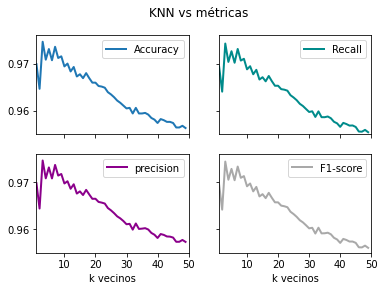

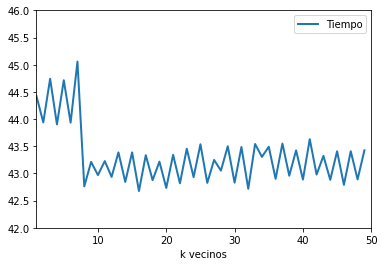

In [27]:
A = pd.read_csv("../results2/KNN/Encontramos_Mejor_k_Con_PCA_en_df_Train.csv")
mejorParametroEncontrado(A,"k")
graficarMetricas(A, "k", "KNN vs métricas", "k vecinos", [1,50], [0.955,0.976])
graficarTiempo(A, "k", "KNN vs Tiempo", "k vecinos", [1,50], [42,46])

## 5) Evaluamos PCA vs KNN
 
* Se tomo un dataset de 42000 imágenes
* Parámetros de $K = 1$
* En A1 no se tomó PCA, en A2 $\alpha = 36$
* $k = [1...30]$


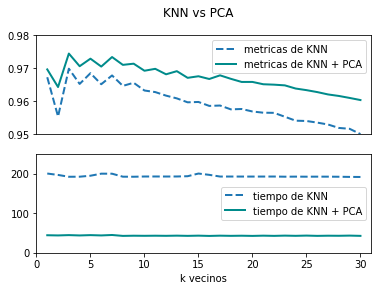

In [28]:
A1 = pd.read_csv("../results2/KNN/Encontramos_Mejor_k_de_KNN_en_dfTrain.csv")
A2 = pd.read_csv("../results2/KNN/Encontramos_Mejor_k_Con_PCA_en_df_Train.csv")

compararPredictores(A1,A2, "k", "KNN vs PCA", "k vecinos", [0,31],ylimMetricas=[0.95,0.98], ylimTiempo=[0,250],legendA1= "KNN", legendA2="KNN + PCA")

## 6) K-Fold en Df train
* Se tomo el dataset de 42000 imágenes
* Parámetros de $K = [1...20]$
* $\alpha = 36$
* $k = 3$

El mejor parametro es 20
el maximo de la métrica es 0.9751904761904762
El mejor parametro es 20
el maximo de la métrica es 0.975176799796747
El mejor parametro es 20
el maximo de la métrica es 0.9750493851228634
El mejor parametro es 20
el maximo de la métrica es 0.9750195346663844


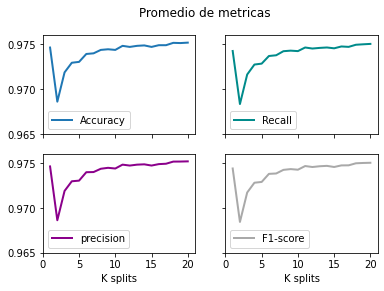

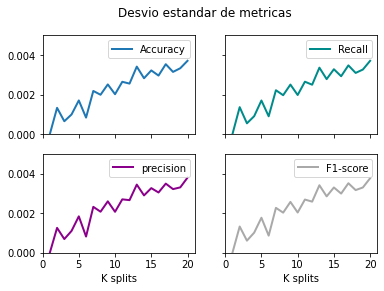

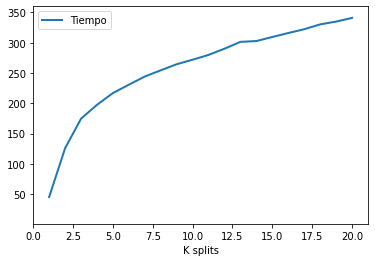

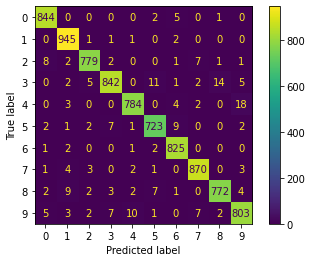

In [29]:
A_mean = pd.read_csv("../results2/K-Fold/Kfold_mean.csv")
A_std = pd.read_csv("../results2/K-Fold/Kfold_std.csv")
A_confusion = pd.read_csv("../results2/K-Fold/Kfold_confusion_dftrain.csv")
mejorParametroEncontrado(A_mean,"K-folds")
graficarMetricas(A_mean, "K-folds","Promedio de metricas", "K splits", [0,21], [0.965,0.976])
graficarMetricas(A_std, "K-folds","Desvio estandar de metricas", "K splits", [0,21], [0,0.005])
graficarTiempo(A_mean,"K-folds", "K-Fold vs Tiempo", "K splits", [0,21], [1,360])
# cuando es kfold = 1, entonce el data test tiene 0.20 del dataset original
# En cambio cuando hay kfold es la suma de todas las instancias del mismo
#con lo que son mas elementos medidos, es todo el dataset
# El indice = K - 1, K = [1...20]
graficar_Confusion_Matrix(A_confusion, 0, True)

## 7) Variamos dataset
* Se tomo el dataset = [100, 500, 1000, 5000, 10000, 20000, 30000, 42000] imagenes
* Parámetros de $K = 1$, $20$ y $5$
* $\alpha = 36$
* $k = 3$

1) Sin Kfold

El mejor parametro es df_42000
el maximo de la métrica es 0.9746428571428573
El mejor parametro es df_42000
el maximo de la métrica es 0.9746110323827124
El mejor parametro es df_42000
el maximo de la métrica es 0.9742597859519913
El mejor parametro es df_42000
el maximo de la métrica es 0.9743846429916396


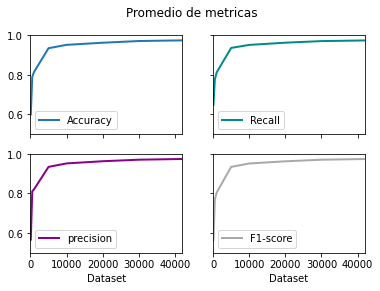

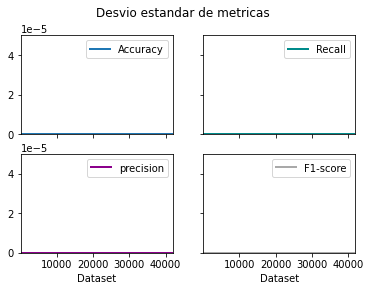

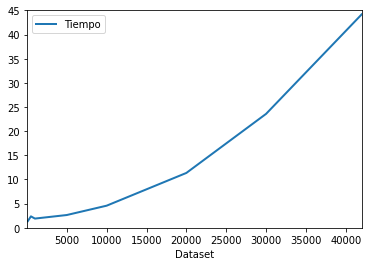

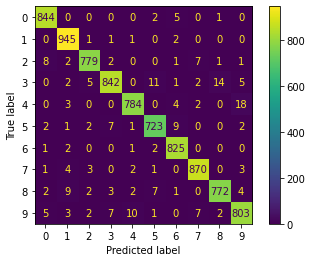

In [30]:
A_mean = pd.read_csv("../results2/VariandoDf/MeanSinKfold.csv")
A_std = pd.read_csv("../results2/VariandoDf/StdSinKfold.csv")
A_confusion = pd.read_csv("../results2/VariandoDf/Confusion_SinKfold.csv")
mejorParametroEncontrado(A_mean,"Dataset")
graficarMetricas(A_mean, "Dataset","Promedio de metricas", "Dataset", [-100,42000], [0.5,1])
graficarMetricas(A_std, "Dataset","Desvio estandar de metricas", "Dataset", [1,42000], [0,0.00005])
graficarTiempo(A_mean,"Dataset", "Dataset vs Tiempo", "Dataset", [1,42000], [0,45])
graficar_Confusion_Matrix(A_confusion, 7, con_etiquetas= True)

2) Con Kfold

El mejor parametro es df_42000
el maximo de la métrica es 0.9751904761904762
El mejor parametro es df_42000
el maximo de la métrica es 0.975176799796747
El mejor parametro es df_42000
el maximo de la métrica es 0.9750493851228634
El mejor parametro es df_42000
el maximo de la métrica es 0.9750195346663844


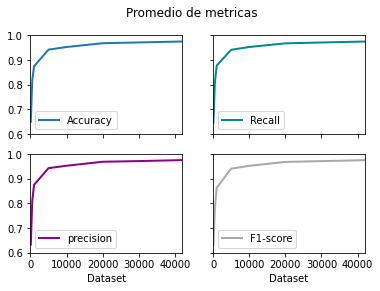

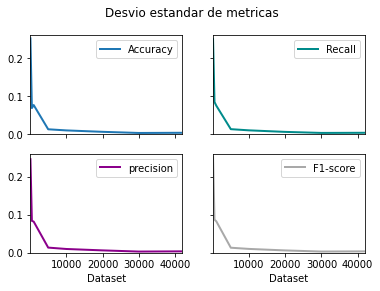

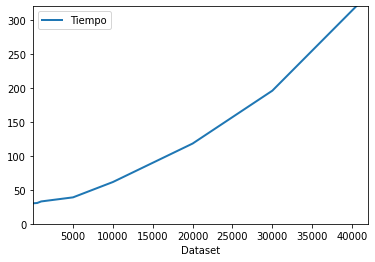

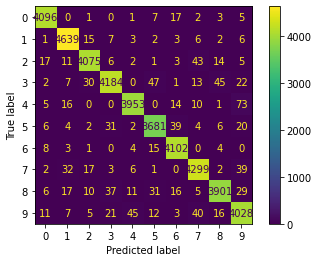

In [31]:
A_mean = pd.read_csv("../results2/VariandoDf/MeanConKfold.csv")
A_std = pd.read_csv("../results2/VariandoDf/StdConKfold.csv")
A_confusion = pd.read_csv("../results2/VariandoDf/Confusion_ConKfold.csv")
mejorParametroEncontrado(A_mean,"Dataset")
graficarMetricas(A_mean, "Dataset","Promedio de metricas", "Dataset", [-100,42000], [0.6,1])
graficarMetricas(A_std, "Dataset","Desvio estandar de metricas", "Dataset", [1,42000], [0,0.26])
graficarTiempo(A_mean,"Dataset", "Dataset vs Tiempo", "Dataset", [1,42000], [0,320])
graficar_Confusion_Matrix(A_confusion, 7, con_etiquetas= True)

3) Con Kfold con $K = 5$

El mejor parametro es df_42000
el maximo de la métrica es 0.973047619047619
El mejor parametro es df_42000
el maximo de la métrica es 0.9730309514508424
El mejor parametro es df_42000
el maximo de la métrica es 0.9728543594699068
El mejor parametro es df_42000
el maximo de la métrica es 0.972886955735164


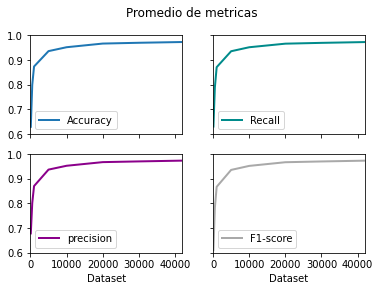

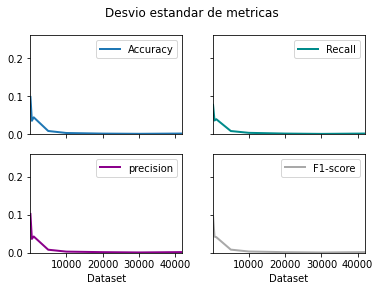

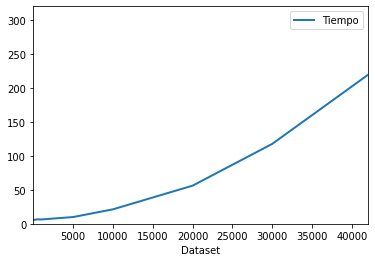

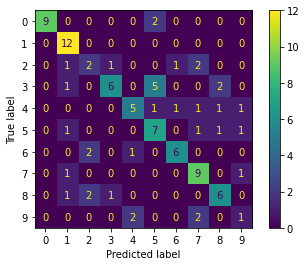

In [32]:
A_mean = pd.read_csv("../results2/VariandoDf/MeanConKfold5.csv")
A_std = pd.read_csv("../results2/VariandoDf/StdConKfold5.csv")
A_confusion = pd.read_csv("../results2/VariandoDf/Confusion_ConKfold5.csv")
mejorParametroEncontrado(A_mean,"Dataset")
graficarMetricas(A_mean, "Dataset","Promedio de metricas", "Dataset", [-100,42000], [0.6,1])
graficarMetricas(A_std, "Dataset","Desvio estandar de metricas", "Dataset", [1,42000], [0,0.26])
graficarTiempo(A_mean,"Dataset", "Dataset vs Tiempo", "Dataset", [1,42000], [0,320])
graficar_Confusion_Matrix(A_confusion, 0, con_etiquetas= True)